In [22]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import chi2
from scipy.stats import norm

i: Historical Simulatio

In [4]:
dog = pd.read_csv("QRM-2025-cw1-data-b(1).csv", parse_dates=["Date"], index_col="Date")
dog["log_return"] = np.log(dog["Adj Close"] / dog["Adj Close"].shift(1))
# For first day we use 0 as log return to avoid nans in the dataframe
dog["lin_loss"] = -dog["log_return"]
dog.fillna(0, inplace=True)
dog.head()

/var/folders/0b/tfp69kqx3697_bkgxskvksmr0000gn/T/ipykernel_31121/2562759880.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dog = pd.read_csv("QRM-2025-cw1-data-b(1).csv", parse_dates=["Date"], index_col="Date")


,Adj Close,log_return,lin_loss
Date,,,
2013-10-30,105.445374,0.000000,0.000000
2013-10-31,105.823196,0.003577,-0.003577
2013-11-01,105.407578,-0.003935,0.003935
2013-11-04,105.256462,-0.001435,0.001435
2013-11-05,105.407578,0.001435,-0.001435


In [5]:
# To follow the style in the lecture slides where the losses were plotted in % we multiply by 100 to achieve the same effect
dog["lin_loss"] = dog["lin_loss"] * 100
dog["log_return"] = dog["log_return"] * 100

To calculate historical foreasts of VaR and ES we calculate the empirical alpha quantile for a rolling windowof 500. 

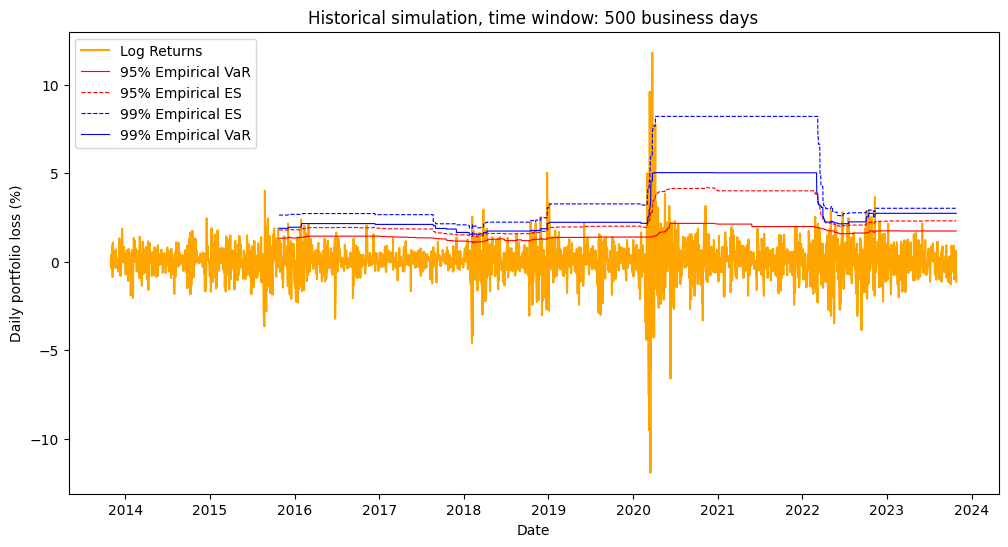

In [6]:
# For VaR simply calculating the rolling empirical quantiles
# At the end we shift by 1, becuase form the definition of the hsitorical VaR forecast we use days 1 to 500 to predict day 501
# So the empirical quantile at day 500 should be used as VaR forecast for day 501
dog["95_emp_VaR_forecast"] = dog["lin_loss"].rolling(window=500).quantile(0.95).shift(1)
dog["99_emp_VaR_forecast"] = dog["lin_loss"].rolling(window=500).quantile(0.99).shift(1)

# For ES we calculate the rolling mean of the losses exceeding the VaR
dog["95_emp_ES_forecast"] = dog["lin_loss"].rolling(window=500).apply(lambda x: x[x >= x.quantile(0.95)].mean()).shift(1)
dog["99_emp_ES_forecast"] = dog["lin_loss"].rolling(window=500).apply(lambda x: x[x >= x.quantile(0.99)].mean()).shift(1)

figure = plt.figure(figsize=(12,6))
plt.plot(dog.index, dog["lin_loss"], label="Log Returns", color="orange")
plt.plot(dog.index, dog["95_emp_VaR_forecast"], label="95% Empirical VaR", color="red", linewidth=0.8)
plt.plot(dog.index, dog["95_emp_ES_forecast"], label="95% Empirical ES", color="red", linestyle="dashed", linewidth=0.8)
plt.plot(dog.index, dog["99_emp_ES_forecast"], label="99% Empirical ES", color="blue", linestyle="dashed", linewidth=0.8)
plt.plot(dog.index, dog["99_emp_VaR_forecast"], label="99% Empirical VaR", color="blue", linewidth=0.8)
plt.legend()
plt.title("Historical simulation, time window: 500 business days")
plt.xlabel("Date")
plt.ylabel("Daily portfolio loss (%)")
plt.show()

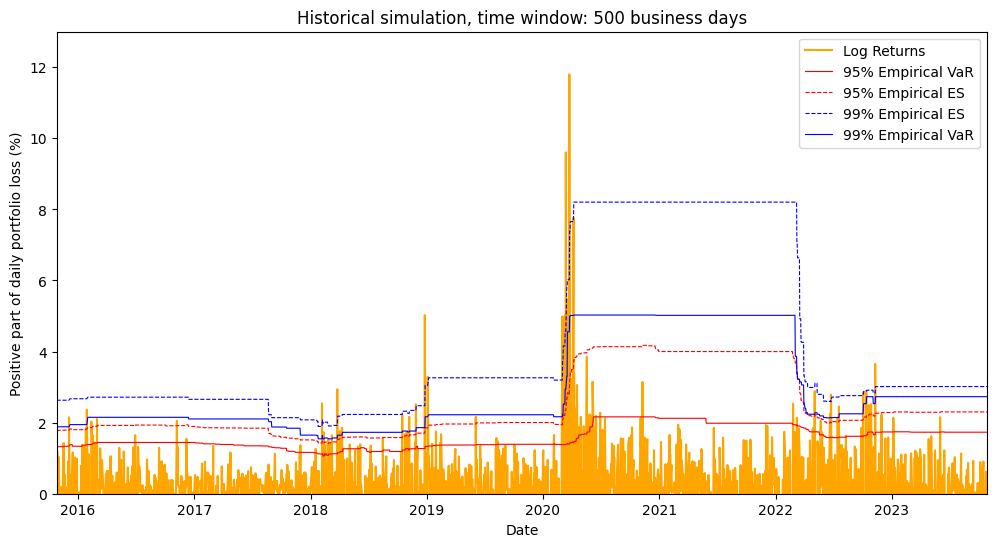

In [7]:
# Same plot as before but only positive parts of the losses and only starting from 500th day, so we plot all the VaR and ES values
figure = plt.figure(figsize=(12,6))
plt.plot(dog.index, dog["lin_loss"], label="Log Returns", color="orange")
plt.plot(dog.index, dog["95_emp_VaR_forecast"], label="95% Empirical VaR", color="red", linewidth=0.8)
plt.plot(dog.index, dog["95_emp_ES_forecast"], label="95% Empirical ES", color="red", linestyle="dashed", linewidth=0.8)
plt.plot(dog.index, dog["99_emp_ES_forecast"], label="99% Empirical ES", color="blue", linestyle="dashed", linewidth=0.8)
plt.plot(dog.index, dog["99_emp_VaR_forecast"], label="99% Empirical VaR", color="blue", linewidth=0.8)
plt.legend()
plt.title("Historical simulation, time window: 500 business days")
plt.xlabel("Date")
plt.ylabel("Positive part of daily portfolio loss (%)")
plt.xlim(dog.index[501], dog.index[-1])
plt.ylim(0, 13)
plt.show()

ii: Filtered historical simulation

For fitting the EWMA we use the sample variance of the complete time series as starting value. (Other ideas?)

In [8]:
# EWMA volatility forecast
sample_variance = dog["lin_loss"].var()
alpha = 0.06
dog["vol_forecast"] = sample_variance
for t in range(1, len(dog)):
    dog["vol_forecast"].iloc[t] = alpha * (dog["lin_loss"].iloc[t-1])**2 + (1 - alpha) * dog["vol_forecast"].iloc[t-1]

/var/folders/0b/tfp69kqx3697_bkgxskvksmr0000gn/T/ipykernel_31121/3211572418.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dog["vol_forecast"].iloc[t] = alpha * (dog["lin_loss"].iloc[t-1])**2 + (1 - alpha) * dog["vol_forecast"].iloc[t-1

Estimating the standardised residuals: 

$\hat{Z}_t = \frac{\hat{\epsilon}_t}{\hat{\sigma}_t}, t = 0,1, \dots, T $ 

where $\hat{\epsilon}_t = X_t - \hat{\mu}_t = X_t $ (since we chose standard mean 0 before, ore should we model mean differently?)

If we calculated that for all, we calculate predicitions for VaR, ES with the following formulas from the lecture slides:

\begin{align*}
\text{VaR}_{\alpha}(L_{t+1}) &= \mu_{t+1} + \sigma_{t+1} q_{\alpha}(Z_{t+1}), \\
\text{ES}_{\alpha}(L_{t+1}) &= \mu_{t+1} + \sigma_{t+1} \text{ES}_{\alpha}(Z_{t+1}),
\end{align*}

Here we estimate $q_{\alpha}(Z_{t+1})$ and $\text{ES}_{\alpha}(Z_{t+1})$ like we did before, but now using the standardised residuals of a rolling 500 window:

In [9]:
dog["residual"] = dog["lin_loss"]/np.sqrt(dog["vol_forecast"])
dog["95_FHS_VaR_forecast"] = np.sqrt(dog["vol_forecast"]) * dog["residual"].rolling(window=500).quantile(0.95).shift(1)
dog["99_FHS_VaR_forecast"] = np.sqrt(dog["vol_forecast"]) * dog["residual"].rolling(window=500).quantile(0.99).shift(1)
dog["95_FHS_ES_forecast"] = np.sqrt(dog["vol_forecast"]) * dog["residual"].rolling(window=500).apply(lambda x: x[x >= x.quantile(0.95)].mean()).shift(1) 
dog["99_FHS_ES_forecast"] = np.sqrt(dog["vol_forecast"]) * dog["residual"].rolling(window=500).apply(lambda x: x[x >= x.quantile(0.99)].mean()).shift(1)

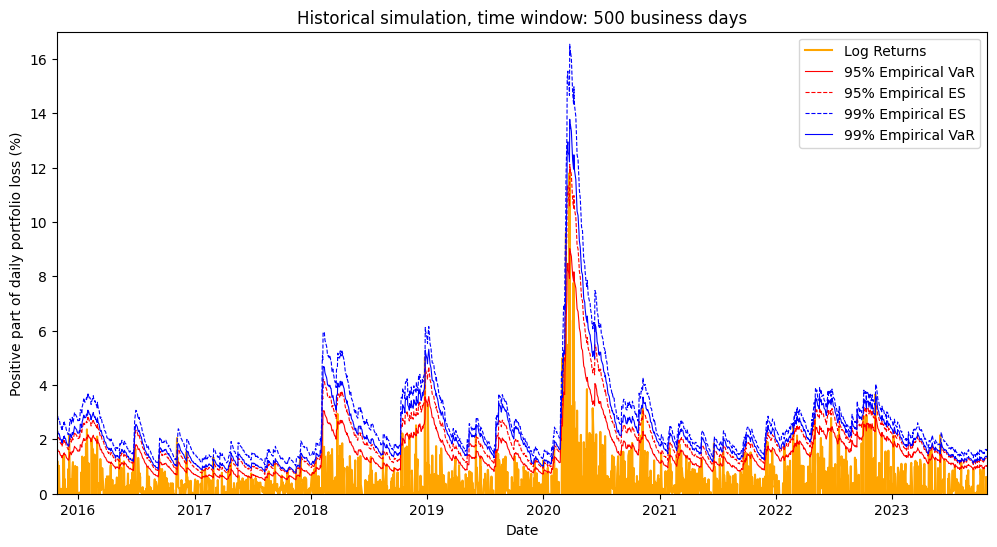

In [10]:
figure = plt.figure(figsize=(12,6))
plt.plot(dog.index, dog["lin_loss"], label="Log Returns", color="orange")
plt.plot(dog.index, dog["95_FHS_VaR_forecast"], label="95% Empirical VaR", color="red", linewidth=0.8)
plt.plot(dog.index, dog["95_FHS_ES_forecast"], label="95% Empirical ES", color="red", linestyle="dashed", linewidth=0.8)
plt.plot(dog.index, dog["99_FHS_ES_forecast"], label="99% Empirical ES", color="blue", linestyle="dashed", linewidth=0.8)
plt.plot(dog.index, dog["99_FHS_VaR_forecast"], label="99% Empirical VaR", color="blue", linewidth=0.8)
plt.legend()
plt.title("Historical simulation, time window: 500 business days")
plt.xlabel("Date")
plt.ylabel("Positive part of daily portfolio loss (%)")
plt.xlim(dog.index[501], dog.index[-1])
plt.ylim(0, 17)
plt.show()

iii: FHS with GARCH

In [ ]:
# Fitting the GARCH model and making the FHS forecasts based on GARCH volatility estimates
dog["95_FHS_GARCH_VaR_forecast"] = np.nan
dog["99_FHS_GARCH_VaR_forecast"] = np.nan
dog["95_FHS_GARCH_ES_forecast"] = np.nan
dog["99_FHS_GARCH_ES_forecast"] = np.nan

dog["rolling_GARCH_vol"] = np.nan
for i in range(500, len(dog)):
    # Select rolling window
    window_data = dog['log_return'].iloc[i-500:i]
    
    # Define GARCH(1,1)
    am = arch_model(window_data, vol='GARCH', p=1, q=1, mean='constant', dist='normal')
    res = am.fit(disp='off')
    # the constant mean that is astimated by the model:
    mu_i = res.params['mu']

    standardized_residuals = res.std_resid.dropna()
    
    # Get the one-step-ahead forecast of volatility
    forecast = res.forecast(horizon=1)
    sigma2 = forecast.variance.values[-1, 0]
    sigma_i = np.sqrt(sigma2)
    
    dog["rolling_GARCH_vol"].iloc[i] = sigma_i

    VaR_Z_95 = standardized_residuals.quantile(0.95)
    ES_Z_95 = standardized_residuals[standardized_residuals >= VaR_Z_95].mean()
    
    # 99% VaR (alpha=0.01, looking for the 99th percentile on losses)
    VaR_Z_99 = standardized_residuals.quantile(0.99)
    ES_Z_99 = standardized_residuals[standardized_residuals >= VaR_Z_99].mean()

    
    # Predictions of VaR and ES
    dog["95_FHS_GARCH_VaR_forecast"].iloc[i] = mu_i + sigma_i * VaR_Z_95
    dog["99_FHS_GARCH_VaR_forecast"].iloc[i] = mu_i + sigma_i * VaR_Z_99
    dog["95_FHS_GARCH_ES_forecast"].iloc[i] = mu_i + sigma_i * ES_Z_95
    dog["99_FHS_GARCH_ES_forecast"].iloc[i] = mu_i + sigma_i * ES_Z_99

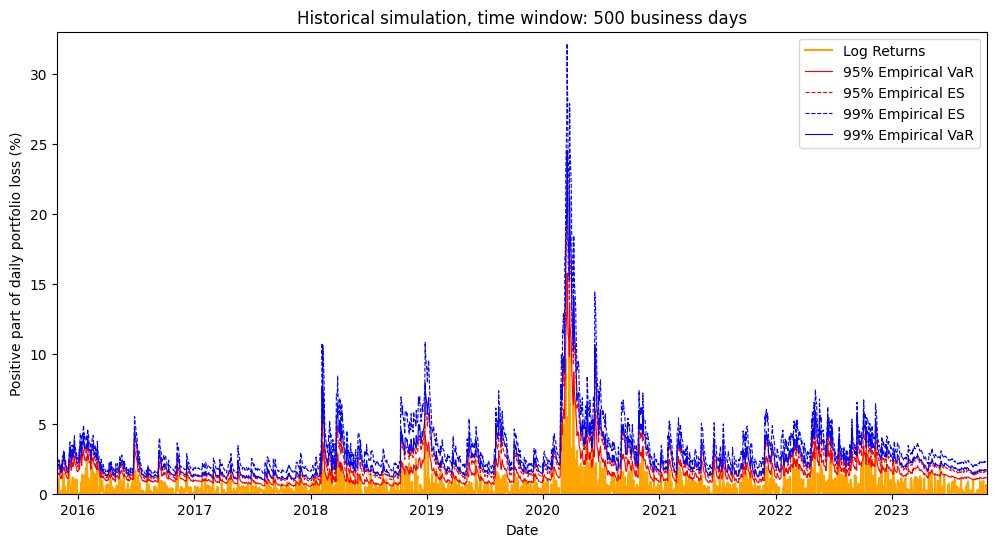

In [12]:
figure = plt.figure(figsize=(12,6))
plt.plot(dog.index, dog["lin_loss"], label="Log Returns", color="orange")
plt.plot(dog.index, dog["95_FHS_GARCH_VaR_forecast"], label="95% Empirical VaR", color="red", linewidth=0.8)
plt.plot(dog.index, dog["95_FHS_GARCH_ES_forecast"], label="95% Empirical ES", color="red", linestyle="dashed", linewidth=0.8)
plt.plot(dog.index, dog["99_FHS_GARCH_ES_forecast"], label="99% Empirical ES", color="blue", linestyle="dashed", linewidth=0.8)
plt.plot(dog.index, dog["99_FHS_GARCH_VaR_forecast"], label="99% Empirical VaR", color="blue", linewidth=0.8)
plt.legend()
plt.title("Historical simulation, time window: 500 business days")
plt.xlabel("Date")
plt.ylabel("Positive part of daily portfolio loss (%)")
plt.xlim(dog.index[501], dog.index[-1])
plt.ylim(0, 33)
plt.show()

Backtest of VaR:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Unconditional Coverage Test
def unconditional_coverage_test(df, alpha, forecast_column, loss_column):
    df = df.dropna(subset=[forecast_column, loss_column])
    T = len(df)
    df["violation"] = (df[loss_column] > df[forecast_column]).astype(int)
    N1 = np.sum(df["violation"])
    N0 = T - N1
    alpha_hat = N1 / T

    # Kupiec's LR_uc Test Statistic
    LR_uc = -2 * (
        (N0 * np.log(1 - alpha) + N1 * np.log(alpha)) - 
        (N0 * np.log(1 - alpha_hat) + N1 * np.log(alpha_hat))
    )

    # P-value (degrees of freedom = 1)
    p_value_uc = 1 - chi2.cdf(LR_uc, 1)

    print(f"Total Observations (T): {T}")
    print(f"Violations (Expected): {N1} ({T * alpha:.0f})")
    print(f"LR_uc Statistic: {LR_uc:.3f}")
    print(f"LR_uc P-value: {p_value_uc:.3f}")

forecasts_alphas = [
    ("95_emp_VaR_forecast", 0.05),
    ("99_emp_VaR_forecast", 0.01),
    ("95_FHS_VaR_forecast", 0.05),
    ("99_FHS_VaR_forecast", 0.01),
    ("95_FHS_GARCH_VaR_forecast", 0.05),
    ("99_FHS_GARCH_VaR_forecast", 0.01)
]
for forecast_column, alpha in forecasts_alphas:
    print(f"\nUnconditional Coverage Test for {forecast_column} at alpha={alpha}:")
    unconditional_coverage_test(dog, alpha, forecast_column, "lin_loss")




Unconditional Coverage Test for 95_emp_VaR_forecast at alpha=0.05:
Total Observations (T): 2016
Violations (Expected): 99 (101)
LR_uc Statistic: 0.034
LR_uc P-value: 0.854

Unconditional Coverage Test for 99_emp_VaR_forecast at alpha=0.01:
Total Observations (T): 2016
Violations (Expected): 30 (20)
LR_uc Statistic: 4.218
LR_uc P-value: 0.040

Unconditional Coverage Test for 95_FHS_VaR_forecast at alpha=0.05:
Total Observations (T): 2016
Violations (Expected): 99 (101)
LR_uc Statistic: 0.034
LR_uc P-value: 0.854

Unconditional Coverage Test for 99_FHS_VaR_forecast at alpha=0.01:
Total Observations (T): 2016
Violations (Expected): 23 (20)
LR_uc Statistic: 0.387
LR_uc P-value: 0.534

Unconditional Coverage Test for 95_FHS_GARCH_VaR_forecast at alpha=0.05:
Total Observations (T): 2016
Violations (Expected): 101 (101)
LR_uc Statistic: 0.000
LR_uc P-value: 0.984

Unconditional Coverage Test for 99_FHS_GARCH_VaR_forecast at alpha=0.01:
Total Observations (T): 2016
Violations (Expected): 8 (2

In [21]:
# --- Joint Coverage and Independence Test ---
def conditional_coverage_test(df, alpha, forecast_column, loss_column):
    df = df.dropna(subset=[forecast_column, loss_column]).copy()
    T = len(df)

    df["violation"] = (df[loss_column] > df[forecast_column]).astype(int)
    I_t = df["violation"].values

    # Calculate Transition Counts (N_ij)
    N00 = np.sum((I_t[:-1] == 0) & (I_t[1:] == 0))
    N01 = np.sum((I_t[:-1] == 0) & (I_t[1:] == 1))
    N10 = np.sum((I_t[:-1] == 1) & (I_t[1:] == 0))
    N11 = np.sum((I_t[:-1] == 1) & (I_t[1:] == 1))
    
    N1 = N01 + N11  # Total violations
    N0 = N00 + N10  # Total non-violations
    T_prime = N00 + N01 + N10 + N11 # T-1


    Pi01_hat = N01 / (N00 + N01) if (N00 + N01) > 0 else 0
    Pi11_hat = N11 / (N10 + N11) if (N10 + N11) > 0 else 0
    alpha_hat = N1 / T_prime

    # Log-Likelihoods
    L_uc = (N0 * np.log(1 - alpha_hat) if (1 - alpha_hat) > 0 else 0) + \
           (N1 * np.log(alpha_hat) if alpha_hat > 0 else 0)

    L_cc = (N00 * np.log(1 - Pi01_hat) if (1 - Pi01_hat) > 0 else 0) + \
           (N01 * np.log(Pi01_hat) if Pi01_hat > 0 else 0) + \
           (N10 * np.log(1 - Pi11_hat) if (1 - Pi11_hat) > 0 else 0) + \
           (N11 * np.log(Pi11_hat) if Pi11_hat > 0 else 0)
    

    LR_cc = -2 * (L_uc - L_cc)

    p_value_cc = 1 - chi2.cdf(LR_cc, 2)

    # Print Results
    print(f"Total Observations (T'): {T_prime}")
    print(f"Violations: {N1}")
    print(f"LR_cc Statistic: {LR_cc:.3f}")
    print(f"LR_cc P-value: {p_value_cc:.3f}")
    
    # Return the results for easy table generation
    return T_prime, N1, LR_cc, p_value_cc

# --- Execute Joint Coverage Tests ---

print("\n" + "="*50)
print("  Joint Coverage and Independence Tests (LR_cc)")
print("="*50)

for forecast_column, alpha in forecasts_alphas:
    print(f"\nConditional Coverage Test for {forecast_column} at alpha={alpha}:")
    conditional_coverage_test(dog, alpha, forecast_column, "lin_loss")


  Joint Coverage and Independence Tests (LR_cc)

Conditional Coverage Test for 95_emp_VaR_forecast at alpha=0.05:
Total Observations (T'): 2015
Violations: 99
LR_cc Statistic: 4.728
LR_cc P-value: 0.094

Conditional Coverage Test for 99_emp_VaR_forecast at alpha=0.01:
Total Observations (T'): 2015
Violations: 30
LR_cc Statistic: 3.057
LR_cc P-value: 0.217

Conditional Coverage Test for 95_FHS_VaR_forecast at alpha=0.05:
Total Observations (T'): 2015
Violations: 99
LR_cc Statistic: 0.180
LR_cc P-value: 0.914

Conditional Coverage Test for 99_FHS_VaR_forecast at alpha=0.01:
Total Observations (T'): 2015
Violations: 23
LR_cc Statistic: 0.531
LR_cc P-value: 0.767

Conditional Coverage Test for 95_FHS_GARCH_VaR_forecast at alpha=0.05:
Total Observations (T'): 2015
Violations: 101
LR_cc Statistic: 0.001
LR_cc P-value: 1.000

Conditional Coverage Test for 99_FHS_GARCH_VaR_forecast at alpha=0.01:
Total Observations (T'): 2015
Violations: 8
LR_cc Statistic: 0.064
LR_cc P-value: 0.969


In [24]:
# Backtesting ES

def expected_shortfall_backtest(df, es_forecast_column, var_forecast_column, loss_column):
    """
    Performs the McNeil and Frey (2000) Z-test for Expected Shortfall backtesting.
    
    H0: The average tail loss matches the Expected Shortfall forecast.
    Test statistic Z asymptotically follows a standard normal distribution N(0, 1).
    """
    
    # Ensure VaR and ES forecasts exist for the same period as the loss
    required_cols = [es_forecast_column, var_forecast_column, loss_column]
    df_test = df.dropna(subset=required_cols).copy()
    T = len(df_test)
    # Determine the VaR Violation Indicator (I_t)
    df_test["I_t"] = (df_test[loss_column] > df_test[var_forecast_column]).astype(int)
    
    # Calculate the term xi_t = (L_t - ES_t) * I_t
    df_test["xi_t"] = (df_test[loss_column] - df_test[es_forecast_column]) * df_test["I_t"]
    
    # Calculate the Test Statistic Z
    sum_xi = df_test["xi_t"].sum()
    sum_xi_squared = (df_test["xi_t"]**2).sum()
    
    # Check for near-zero denominator to prevent errors
    if sum_xi_squared < 1e-12:
        Z_statistic = np.nan
        p_value = np.nan
        print("Note: Sum of xi_t^2 is near zero. Cannot calculate Z-statistic.")
    else:
        Z_statistic = sum_xi / np.sqrt(sum_xi_squared)
        p_value = 2 * norm.cdf(-np.abs(Z_statistic))

    # --- Print Results ---
    num_violations = df_test["I_t"].sum()
    
    print(f"Total Observations (T): {T}")
    print(f"VaR Violations: {num_violations}")
    print(f"Z-Statistic (ES Test): {Z_statistic:.3f}")
    print(f"P-value (ES Test): {p_value:.3f}")
    
    return T, num_violations, Z_statistic, p_value

print("\n" + "="*50)
print("  Expected Shortfall Backtest (Z-Test)")
print("="*50)

es_forecasts_vaR_pairs = [
    ("95_FHS_ES_forecast", "95_FHS_VaR_forecast"),
    ("99_FHS_ES_forecast", "99_FHS_VaR_forecast"),
    ("95_emp_ES_forecast", "95_emp_VaR_forecast"),
    ("99_emp_ES_forecast", "99_emp_VaR_forecast"),
    ("95_FHS_GARCH_ES_forecast", "95_FHS_GARCH_VaR_forecast"),
    ("99_FHS_GARCH_ES_forecast", "99_FHS_GARCH_VaR_forecast"),
    # Add other ES/VaR pairs as needed
]

for es_col, var_col in es_forecasts_vaR_pairs:
    print(f"\nES Backtest for {es_col} (based on VaR from {var_col}):")
    expected_shortfall_backtest(dog, es_col, var_col, "lin_loss")


  Expected Shortfall Backtest (Z-Test)

ES Backtest for 95_FHS_ES_forecast (based on VaR from 95_FHS_VaR_forecast):
Total Observations (T): 2016
VaR Violations: 99
Z-Statistic (ES Test): 0.248
P-value (ES Test): 0.804

ES Backtest for 99_FHS_ES_forecast (based on VaR from 99_FHS_VaR_forecast):
Total Observations (T): 2016
VaR Violations: 23
Z-Statistic (ES Test): -0.813
P-value (ES Test): 0.416

ES Backtest for 95_emp_ES_forecast (based on VaR from 95_emp_VaR_forecast):
Total Observations (T): 2016
VaR Violations: 99
Z-Statistic (ES Test): 1.125
P-value (ES Test): 0.261

ES Backtest for 99_emp_ES_forecast (based on VaR from 99_emp_VaR_forecast):
Total Observations (T): 2016
VaR Violations: 30
Z-Statistic (ES Test): 1.780
P-value (ES Test): 0.075

ES Backtest for 95_FHS_GARCH_ES_forecast (based on VaR from 95_FHS_GARCH_VaR_forecast):
Total Observations (T): 2016
VaR Violations: 101
Z-Statistic (ES Test): -5.820
P-value (ES Test): 0.000

ES Backtest for 99_FHS_GARCH_ES_forecast (based o